In [1]:
 #this code snippet was used to import our custom dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import all necessary modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa, librosa.display
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# set the variables to work with throughout model
img_height = 256
img_width= 256
rgb = 3
batch_size = 10  
epochs = 50

In [4]:
# set-up training data from the original dataset only
ods_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/original_data_set', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_height),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = 'training',
)

Found 3000 files belonging to 10 classes.
Using 2100 files for training.


In [5]:
# set-up training data using original plus the augmented data as well
plusAugmented_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/plusAugmented', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_height),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = 'training',
)

Found 32898 files belonging to 10 classes.
Using 23029 files for training.


In [6]:
# now create a batch to test with from original dataset
ods_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/original_data_set', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_height),
    shuffle = True,
    seed = 456,
    validation_split = 0.3,
    subset = "validation",
)

Found 3000 files belonging to 10 classes.
Using 900 files for validation.


In [7]:
# also need a batch to test with from the original plus augmented datase
plusAugmented_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/plusAugmented', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_height),
    shuffle = True,
    seed = 456,
    validation_split = 0.3,
    subset = "validation",
)

Found 32898 files belonging to 10 classes.
Using 9869 files for validation.


In [8]:
# the real test....
# NOW, a batch of unseen originals the plusAugmented model has not seen
unseen_test= tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/unseen_originals', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_height),
    shuffle = True,
    seed = 456,
)

Found 102 files belonging to 10 classes.


In [9]:
#  build up model
model = keras.models.Sequential()
model.add(keras.layers.Convolution2D(32, kernel_size = (5, 5), input_shape=(img_height, img_width, rgb ), activation='relu'))
model.add(keras.layers.Convolution2D(16, kernel_size = (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Reshape((125, -1)))
model.add(keras.layers.TimeDistributed(layers.Dense(100)))
model.add(keras.layers.LSTM(100, return_sequences=False))
model.add(keras.layers.Dense(10,activation = 'softmax'))

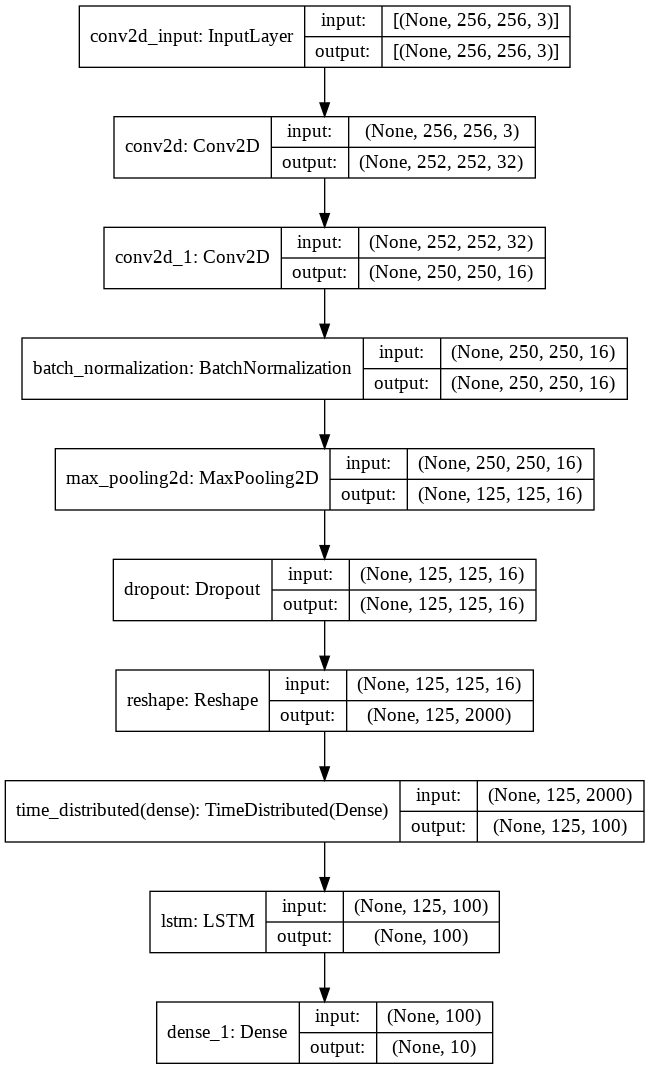

In [10]:
# display model layers w/ input and output
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [11]:
#  compile model
model.compile(optimizer = keras.optimizers.Adam(),
             loss = [ keras.losses.CategoricalCrossentropy(from_logits=True)],
             metrics = [ keras.metrics.CategoricalAccuracy()])

In [12]:
# show a summary of layers and the parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 16)      4624      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
reshape (Reshape)            (None, 125, 2000)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 125, 100)          2

In [13]:
# training the original dataset
ods_history = model.fit(ods_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/50
210/210 [==============================] - 17s 62ms/step - loss: 2.1690 - categorical_accuracy: 0.2255
Epoch 2/50
210/210 [==============================] - 13s 62ms/step - loss: 1.6121 - categorical_accuracy: 0.4336
Epoch 3/50
210/210 [==============================] - 14s 63ms/step - loss: 1.3315 - categorical_accuracy: 0.5372
Epoch 4/50
210/210 [==============================] - 13s 62ms/step - loss: 1.2833 - categorical_accuracy: 0.5705
Epoch 5/50
210/210 [==============================] - 13s 63ms/step - loss: 1.1551 - categorical_accuracy: 0.6172
Epoch 6/50
210/210 [==============================] - 13s 63ms/step - loss: 1.0738 - categorical_accuracy: 0.6433
Epoch 7/50
210/210 [==============================] - 14s 66ms/step - loss: 1.0399 - categorical_accuracy: 0.6517
Epoch 8/50
210/210 [==============================] - 14s 63ms/step - loss: 0.9308 - categorical_accuracy: 0.6911
Epoch 9/50
210/210 [==============================] - 13s 63ms/step - loss: 0.8480 - cat

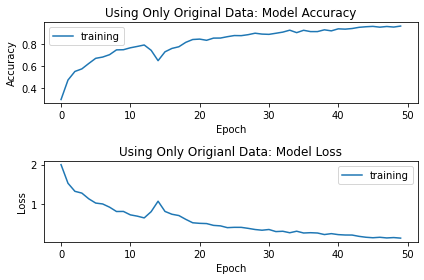

In [14]:
# how did we do?
# graphically display results of training and testing
plt.figure()
plt.subplot(211)
plt.plot(ods_history.history['categorical_accuracy'])
plt.title('Using Only Original Data: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper left')

plt.subplot(212)
plt.plot(ods_history.history['loss'])
plt.title('Using Only Origianl Data: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper right')

plt.tight_layout()
plt.show()

In [15]:
# go ahead and save the model here
model.save("ods_32_e.h5")

In [16]:
# now test the model against the reserved unseen images from the original dataset
ods_t = model.evaluate(ods_test, verbose = 1)
print("Using only original unseen samples:")
print("Accuracy: ", ods_t[1] * 100)
print("Loss: ", ods_t[0])

90/90 [==============================] - 5s 48ms/step - loss: 0.2769 - categorical_accuracy: 0.9278
Using only original unseen samples:
Accuracy:  92.77777671813965
Loss:  0.27691641449928284


In [17]:
# next, we need to train with the original plus the augmented data on the exact same architecture
plusAugmented_history = model.fit(plusAugmented_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/50
2303/2303 [==============================] - 152s 66ms/step - loss: 1.0528 - categorical_accuracy: 0.6624
Epoch 2/50
2303/2303 [==============================] - 154s 67ms/step - loss: 0.7091 - categorical_accuracy: 0.7653
Epoch 3/50
2303/2303 [==============================] - 152s 66ms/step - loss: 0.5353 - categorical_accuracy: 0.8240
Epoch 4/50
2303/2303 [==============================] - 151s 66ms/step - loss: 0.4701 - categorical_accuracy: 0.8435
Epoch 5/50
2303/2303 [==============================] - 152s 66ms/step - loss: 0.3910 - categorical_accuracy: 0.8685
Epoch 6/50
2303/2303 [==============================] - 153s 66ms/step - loss: 0.3628 - categorical_accuracy: 0.8804
Epoch 7/50
2303/2303 [==============================] - 152s 66ms/step - loss: 0.3427 - categorical_accuracy: 0.8870
Epoch 8/50
2303/2303 [==============================] - 153s 66ms/step - loss: 0.2858 - categorical_accuracy: 0.9029
Epoch 9/50
2303/2303 [==============================] - 151s 65m

In [18]:
# save one last time
model.save("pA_32_e.h5")

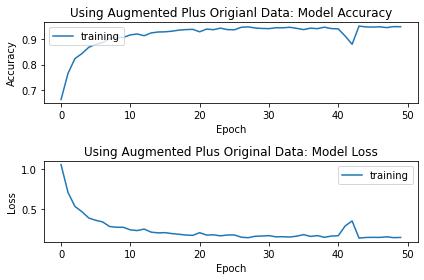

In [19]:
# how did we do?
# graphically display results of training
plt.figure()
plt.subplot(211)
plt.plot(plusAugmented_history.history['categorical_accuracy'])
plt.title('Using Augmented Plus Origianl Data: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper left')

plt.subplot(212)
plt.plot(plusAugmented_history.history['loss'])
plt.title('Using Augmented Plus Original Data: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper right')

plt.tight_layout()
plt.show()
plt.show()

In [20]:
# now let's test with unseen images from the augmented plus original dataset
plusAugment_history_test = model.evaluate(plusAugmented_test, verbose = 1)
print("Using the augmented plus original samples:")
print("Accuracy: ", plusAugment_history_test[1] * 100)
print("Loss: ", plusAugment_history_test[0])

987/987 [==============================] - 52s 52ms/step - loss: 0.8014 - categorical_accuracy: 0.7701
Using the augmented plus original samples:
Accuracy:  77.00881361961365
Loss:  0.801402747631073


In [21]:
# NOW, let's test the plusAugmented model with 100 super secret unseen original images
unseen_test_history = model.evaluate(unseen_test, verbose = 1)
print("Using unseen originals only:")
print("Accuracy: ", unseen_test_history[1] * 100)
print("Loss: ", unseen_test_history[0])

11/11 [==============================] - 1s 20ms/step - loss: 0.7044 - categorical_accuracy: 0.7745
Using unseen originals only:
Accuracy:  77.45097875595093
Loss:  0.7043774724006653
